## Get Backend

In [1]:
from qiskit_ibm_provider import IBMProvider, least_busy

provider = IBMProvider()

backends_info = {
    'ibm_canberra' : "q-info-hackathon/team-21/main",
    'ibmq_mumbai' : "ibm-q-skku/hackathon-2023/hackathon",
    'ibm_hanoi' : 'ibm-q-skku/hackathon-2023/hackathon'
    }

backend_name, instance = list(backends_info.items())[0]

backend = provider.get_backend(backend_name, instance=instance)
print(f"Using {backend.name}")

Using ibm_canberra


## Make and Transpile Circuits

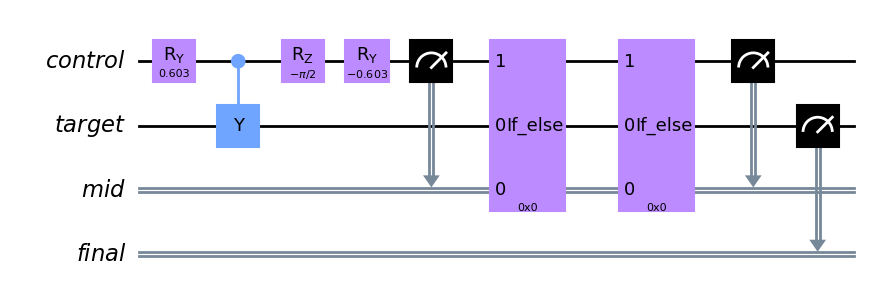

In [36]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from qiskit import transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

def trial(circuit, target, control, theta, measure):
    """Probabilistically perform an Rx gate for an
    angle that is an irrational multiple of pi."""
    circuit.ry(2*theta, control)
    circuit.cy(control, target)
    circuit.rz(-np.pi/2, control)
    circuit.ry(-2*theta, control)
    circuit.measure(control, measure)

def repeat_block(circuit, control, theta, measure):
    with circuit.if_test((measure, 0)) as else_:
        pass
    with else_:
        # Reset the control and target.
        circuit.x(control)
        circuit.ry(-np.pi/2, target)
        # Then repeat the trial.
        trial(circuit, target, control, theta, mid_measure)

def RUS_circuit_1fold(theta, max_trials=2):
    control = QuantumRegister(1, name="control")
    target = QuantumRegister(1, name="target")
    mid_measure = ClassicalRegister(1, name="mid")
    final_measure = ClassicalRegister(1, name="final")
    circuit = QuantumCircuit(control, target, mid_measure, final_measure)

    # make circuit
    trial(circuit, target, control, theta, mid_measure)
    for _ in range(max_trials - 1): repeat_block(circuit, control, theta, mid_measure)
    circuit.measure(control, mid_measure)
    circuit.measure(target, final_measure)

    return circuit

# def RUS_circuit_2fold(theta, max_trials=2):
#     control = QuantumRegister(2, name="control")
#     target = QuantumRegister(1, name="target")
#     mid_measure = ClassicalRegister(2, name="mid")
#     final_measure = ClassicalRegister(1, name="final")
#     circuit = QuantumCircuit(control, target, mid_measure, final_measure)

#     def trial(circuit, target, control, theta, measure, y_phase):
#         # make circuit
#         circuit.ry(2*theta, control)
#         if y_phase == 'i':
#             circuit.cry(-np.pi, control, target)
#         elif y_phase == '-i':
#             circuit.cry(np.pi, control, target)
#         circuit.rz(-np.pi/2, control)
#         circuit.ry(-2*theta, control)
#         circuit.measure(control, measure)
    
#     trial(circuit, control[1], control[0], mid_measure[0], y_phase='-i')
#     for _ in range(max_trials - 1):
#         with circuit.if_test((mid_measure, 0)) as else_:
#             pass
#         with else_:
#             # Reset the control and target.
#             circuit.x(control)
#             circuit.ry(-np.pi, target)
#             # Then repeat the trial.
#             trial(circuit, target, control, theta, mid_measure, y_phase='i')

#     circuit.cry(np.pi, control[1], target)
#     circuit.reset(control[0])

#     trial(circuit, control[1], control[0], mid_measure[0], y_phase='i')
#     for _ in range(max_trials - 1):
#         with circuit.if_test((mid_measure, 0)) as else_:
#             pass
#         with else_:
#             # Reset the control and target.
#             circuit.x(control)
#             circuit.ry(-np.pi, target)
#             # Then repeat the trial.
#             trial(circuit, target, control, theta, mid_measure, y_phase='-i')

#     return circuit

thetas = np.linspace(0, np.pi/2, 100)
circuits = []

for i, theta in enumerate(thetas):
    circuits.append(RUS_circuit_1fold(theta, max_trials=3))

# transpile
builts = [transpile(circuits[i], backend) for i in range(len(circuits))]

circuits[19].draw('mpl')

## Get Result

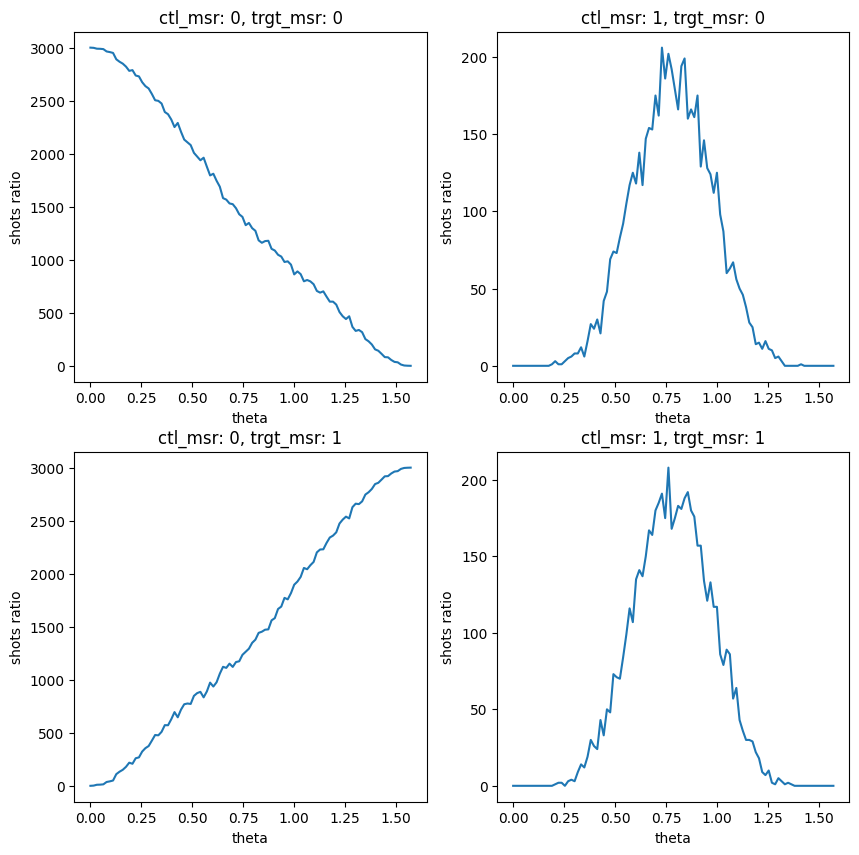

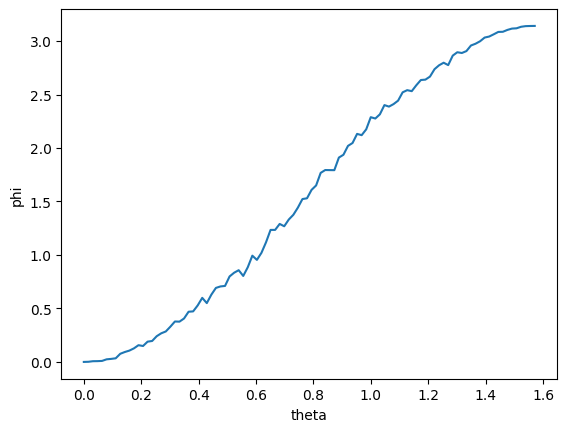

In [37]:
import numpy as np

# simulate
sim = AerSimulator(method="statevector")

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

plot_data = [{'x':thetas, 'y':[]}, {'x':thetas, 'y':[]}, {'x':thetas, 'y':[]}, {'x':thetas, 'y':[]}]

num_shots = 3000

for built in builts:
    simulator_result = sim.run(built, shots=num_shots).result()
    simulator_counts = simulator_result.get_counts()
    keys = ['0 0', '0 1', '1 0', '1 1']
    for k in keys :
        if k not in simulator_counts.keys():
            simulator_counts[k] = 0\
    
    for k, v in simulator_counts.items():
        if k == '0 0':
            plot_data[0]['y'].append(v)
        elif k == '0 1':
            plot_data[1]['y'].append(v)
        elif k == '1 0':
            plot_data[2]['y'].append(v)
        if k == '1 1':
            plot_data[3]['y'].append(v)

for i, data in enumerate(plot_data):
    axs[i//2, i%2].plot(data['x'], data['y'])
    axs[i//2, i%2].title.set_text(f'ctl_msr: {i%2}, trgt_msr: {i//2}')
    axs[i//2, i%2].set(xlabel="theta", ylabel="shots ratio")

plt.show()
plt.close()

final_0 = plot_data[0]['y']
final_1 = plot_data[2]['y']
phi_list = []
for i in range(len(final_0)):
    phi_list.append(2*np.arctan(final_1[i]/final_0[i]) if final_0[i] != 0 else np.pi)
    
plt.figure()
plt.plot(data['x'], phi_list)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()
plt.close()